In [2]:
from Bio import Align
from Bio.Align import substitution_matrices
import re
import numpy as np
import pandas as pd
import duckdb
import time

In [14]:
help(Align.PairwiseAligner)

Help on class PairwiseAligner in module Bio.Align:

class PairwiseAligner(_algorithms.PairwiseAligner)
 |  PairwiseAligner(scoring=None, **kwargs)
 |  
 |  Performs pairwise sequence alignment using dynamic programming.
 |  
 |  This provides functions to get global and local alignments between two
 |  sequences.  A global alignment finds the best concordance between all
 |  characters in two sequences.  A local alignment finds just the
 |  subsequences that align the best.
 |  
 |  To perform a pairwise sequence alignment, first create a PairwiseAligner
 |  object.  This object stores the match and mismatch scores, as well as the
 |  gap scores.  Typically, match scores are positive, while mismatch scores
 |  and gap scores are negative or zero.  By default, the match score is 1,
 |  and the mismatch and gap scores are zero.  Based on the values of the gap
 |  scores, a PairwiseAligner object automatically chooses the appropriate
 |  alignment algorithm (the Needleman-Wunsch, Smith-Wa

In [3]:
def get_matches_gaps(query, subject):
    
    n_columns = len(query)
    
    n_gaps = sum(i == '-' for i in query) + sum(i == '-' for i in subject)
    n_matches = sum(i == j and i != '-' for i,j in zip(query, subject))
    pattern = r'(-{1,})'
    instances = re.findall(pattern, query) + re.findall(pattern, subject)
    n_comp_gaps = len(instances)
    return n_matches, n_gaps, n_columns, n_comp_gaps

def gap_compressed_percent_id(n_matches, n_gaps, n_columns, n_comp_gaps):
    """Percent matches in sequence, including but compressing gaps.

    Parameters
    ----------
    n_matches : int, number of matches in match columns
    n_gaps : number of gaps in match columns
    n_columns : total number of alignment match columns
    n_compressed_gaps : number of compressed gaps in match columns
    """
    return n_matches / (n_columns - n_gaps + n_comp_gaps)

In [4]:
path = '/mnt/s/FAFSA/FAFSA_lite.db'

con = duckdb.connect(path)

In [5]:
con.execute("""SELECT TABLE_NAME
FROM INFORMATION_SCHEMA.TABLES
WHERE TABLE_TYPE='BASE TABLE'""").df()

,table_name
0,fafsa_final


In [9]:
sequences1 = con.execute("""SELECT * FROM fafsa_final LIMIT 5""").df()['m_protein_seq']
sequences2 = con.execute("""SELECT * FROM fafsa_final LIMIT 5""").df()['t_protein_seq']

In [62]:
# Set the gap penalties
# query is sequence 2 in this code

# # Perform pairwise local sequence alignment

aligner = Align.PairwiseAligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
aligner.open_gap_score = -11
aligner.extend_gap_score = -1
aligner.mode = 'local'

alignments = []
for i, seq1 in enumerate(sequences1):
    alignment = aligner.align(seq1, sequences2[i])
    best_alignment = max(alignment, key=lambda x: x.score)
    alignments.append(best_alignment)
    
# Calculate alignment coverage
for i, alignment in enumerate(alignments):
    seq1_aligned = alignment[0]
    seq2_aligned = alignment[1]

    # Calculate coverage for sequence 1
    coverage1 = sum(c != '-' for c in seq1_aligned) / len(seq1_aligned) * 100

    # Calculate coverage for sequence 2
    coverage2 = sum(c != '-' for c in seq2_aligned) / len(seq2_aligned) * 100
    matches = sum(c1 == c2 and c1 != '-' for c1, c2 in zip(seq1_aligned, seq2_aligned))
    length = len(seq1_aligned.replace('-', ''))
    
    percent_identity = matches / length * 100
    n_matches, n_gaps, n_columns, n_comp_gaps = get_matches_gaps(seq2_aligned, seq1_aligned)
    gap_comp_pct_id = gap_compressed_percent_id(n_matches, n_gaps, n_columns, n_comp_gaps)
    
    scaled_local_symmetric_percent_id = 2 * n_matches / (len(sequences1[i]) + len(sequences2[i]))
    scaled_local_query_percent_id = n_matches / len(sequences2[i])
    print(seq1_aligned)
    print('Score:', alignment.score)
    print('Local gap comp id:', gap_comp_pct_id)
    print('Scaled query id:', scaled_local_query_percent_id)
    print('Scaled sym id:', scaled_local_symmetric_percent_id)

    print("Sub alignment coverage:", coverage1)
    print("Query alignment coverage:", coverage2)
    print('Sub length', len(seq1_aligned))
    print('Query length', len(seq2_aligned))
    print('\n')

n_gaps: 12
n_match: 80
n_comp_gaps: 6
ALSQLGDPRFRRVLGLGIILTFALLIASYAGLLWVLDLLVGEDAYVPVIGQVTWLDDLLSFSSFIFMFILSIFLMVPVASAITSMFLDDVAQAVEDRHYP-NLPAVDPVPFSDALRDTLYFLGVLIIANLLAFILYAFFSALSVFIFWGLNGFLLGREYFQLAAMRRLGRQGAAALRKKNKGTIWLAGILMAVPLSIPLVNLLIPIVGAATFTHLFHQI-QAADDPSS
Score: 309.0
Local gap comp id: 0.36036036036036034
Scaled query id: 0.34934497816593885
Scaled sym id: 0.3389830508474576
Sub alignment coverage: 99.12280701754386
Query alignment coverage: 95.6140350877193
Sub length 228
Query length 228


n_gaps: 0
n_match: 47
n_comp_gaps: 0
MEGKVKWFNAEKGYGFIETSEGGDVFVHFSAIQTDGFKTLDEGQSVEFDIVEGARGPQAANVIKL
Score: 263.0
Local gap comp id: 0.7230769230769231
Scaled query id: 0.7230769230769231
Scaled sym id: 0.7230769230769231
Sub alignment coverage: 100.0
Query alignment coverage: 100.0
Sub length 65
Query length 65


n_gaps: 5
n_match: 46
n_comp_gaps: 3
ILETERLKLRELTLLDAETMFYYFEKASVIRYFGMDSFQNMEQVKNTIQTFRKRYEEGNVLRWGIELKGTNQLIGTFGF--HLINPNHKRAEIGYELDDTYWGKGYASEALQAILTYGFETLQLIRIAAVVYTENE

In [47]:
con.execute("""SELECT * FROM fafsa_final LIMIT 5""").df()


,m_protein_seq,t_protein_seq,meso_alphafold_id,thermo_alphafold_id,meso_pid,thermo_pid,bit_score,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len
0,MGIALIFKSFFLALSQLGDPRFRRVLGLGIILTFALLIASYAGLLW...,MIADALAALSDVVSAPFRRVLLRSLGLTIAVLVGLWLLLVSVIGSY...,A0A4U7N8C1,A0A4R3MEU4,A0A4U7N8C1,A0A4R3MEU4,246.0,0.368664,0.349345,0.338983,218,0.951965,226,0.930041,28.0,50.0,22.0,243,229
1,MEGKVKWFNAEKGYGFIETSEGGDVFVHFSAIQTDGFKTLDEGQSV...,MVGKVKWFNSEKGFGFIECEDGNDVFVHYTAINENGFKSLEEGQSV...,A0A098MCX1,A0A419SWC1,A0A098MCX1,A0A419SWC1,264.0,0.723077,0.723077,0.723077,65,1.000000,65,1.000000,22.0,65.0,43.0,65,65
2,MGFPILETERLKLRELTLLDAETMFYYFEKASVIRYFGMDSFQNME...,MAVLETKRLILRQYEDEDIIPLHCIFSDPETMKFYPSPFSIQQTQD...,A0A2B6IPT3,A0A178TR74,A0A2B6IPT3,A0A178TR74,190.0,0.310811,0.275449,0.265130,147,0.880240,148,0.822222,30.0,55.0,25.0,180,167
3,MSARILVVDNYDSFVFNLVQYLYQLGAECEVLRNDEVALSHAQDGF...,MALAKRVVILDYGSGNLRSAERAIARAGAEVEVTSDFDAAVEADGL...,E2PWL5,D6YA12,E2PWL5,D6YA12,105.0,0.313830,0.278302,0.278302,207,0.976415,188,0.886792,28.0,52.5,24.5,212,212
4,MRINKYLAETGVVSRRGADAWIEAGRITINDELATLGSKVEDGDVV...,MERLQKVIAQAGIASRRKAEQLILEGKVKVNGEVVKALGTKVSRSD...,A0A1C0YLC9,A0A4P6URQ6,A0A1C0YLC9,A0A4P6URQ6,307.0,0.381579,0.356557,0.364780,232,0.950820,223,0.957082,29.0,50.0,21.0,233,244


In [134]:
def make_blast_df(data):
    start = time.time()
    original_cols = data.columns

    data.rename(columns = {original_cols[0]: 'query', original_cols[1]: 'subject'}, inplace = True)

    n_unique_1 = np.unique(data['query'])
    n_unique_2 = np.unique(data['subject'])

    qid_dict = dict(zip(n_unique_1, range(len(n_unique_1))))
    sid_dict = dict(zip(n_unique_2, range(len(n_unique_2))))

    data['qid'] = [qid_dict[i] for i in data.iloc[:,0]]
    data['sid'] = [sid_dict[i] for i in data.iloc[:,1]]

    data['pid'] = data.index

    metrics = [
    'local_gap_compressed_percent_id',
    'scaled_local_query_percent_id',
    'scaled_local_symmetric_percent_id',
    'query_align_len',
    'query_align_cov',
    'subject_align_len',
    'subject_align_cov',
    'bit_score'
    ]

    data_dict = data.to_dict('records')
    final = pd.DataFrame(columns = metrics)
    
        
    # Initialize PairWiseAligner with required parameters for model
    aligner = Align.PairwiseAligner()
    aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
    aligner.open_gap_score = -11
    aligner.extend_gap_score = -1
    aligner.mode = 'local'

    alignments = []
    for row in data_dict:
  
        query = row['query']
        subject = row['subject']
        
        alignment = aligner.align(subject, query)
        best_alignment = max(alignment, key=lambda x: x.score)
        alignments.append(best_alignment)

    # Calculate alignment coverage
    for i, alignment in enumerate(alignments):

        seq1_aligned = alignment[0]
        seq2_aligned = alignment[1]

        subject_cov = sum(c != '-' for c in seq1_aligned) / len(seq1_aligned) * 100
        query_cov = sum(c != '-' for c in seq2_aligned) / len(seq2_aligned) * 100
        
        l_subject = sum(c != '-' for c in seq1_aligned)
        l_query = sum(c != '-' for c in seq2_aligned)
        
        n_matches, n_gaps, n_columns, n_comp_gaps = get_matches_gaps(seq2_aligned, seq1_aligned)
        gap_comp_pct_id = gap_compressed_percent_id(n_matches, n_gaps, n_columns, n_comp_gaps)

        scaled_local_symmetric_percent_id = 2 * n_matches / (l_subject + l_query)
        scaled_local_query_percent_id = n_matches / l_query
        
        new_row = dict(zip(metrics, [[gap_comp_pct_id], [scaled_local_query_percent_id], 
                                     [scaled_local_symmetric_percent_id], [l_query], [query_cov], 
                                     [l_subject], [subject_cov], [alignment.score]]))
        
        final = pd.concat([final, pd.DataFrame.from_dict(new_row)], ignore_index = True)
    final['query_id'] = data['qid']
    final['subject_id'] = data['sid']
    
    blast_df = data.merge(final, left_on = ['qid','sid'], right_on = ['query_id','subject_id'])
        
    fin = time.time()
    
    tot = fin - start
    
    return blast_df, tot
 

In [131]:
test = con.execute("""SELECT * FROM fafsa_final LIMIT 5""").df()[['m_protein_seq', 't_protein_seq']]


In [132]:
make_blast_df(test)

Total time: 0.01763629913330078 seconds


,query,subject,qid,sid,pid,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,query_id,subject_id
0,MGIALIFKSFFLALSQLGDPRFRRVLGLGIILTFALLIASYAGLLW...,MIADALAALSDVVSAPFRRVLLRSLGLTIAVLVGLWLLLVSVIGSY...,2,3,0,0.360360,0.353982,0.360360,226,99.122807,218,95.614035,309.0,2,3
1,MEGKVKWFNAEKGYGFIETSEGGDVFVHFSAIQTDGFKTLDEGQSV...,MVGKVKWFNSEKGFGFIECEDGNDVFVHYTAINENGFKSLEEGQSV...,0,4,1,0.723077,0.723077,0.723077,65,100.000000,65,100.000000,263.0,0,4
2,MGFPILETERLKLRELTLLDAETMFYYFEKASVIRYFGMDSFQNME...,MAVLETKRLILRQYEDEDIIPLHCIFSDPETMKFYPSPFSIQQTQD...,1,1,2,0.310811,0.310811,0.311864,148,98.666667,147,98.000000,185.0,1,1
3,MSARILVVDNYDSFVFNLVQYLYQLGAECEVLRNDEVALSHAQDGF...,MALAKRVVILDYGSGNLRSAERAIARAGAEVEVTSDFDAAVEADGL...,4,0,3,0.313830,0.313830,0.298734,188,86.635945,207,95.391705,126.0,4,0
4,MRINKYLAETGVVSRRGADAWIEAGRITINDELATLGSKVEDGDVV...,MERLQKVIAQAGIASRRKAEQLILEGKVKVNGEVVKALGTKVSRSD...,3,2,4,0.385965,0.394619,0.386813,223,95.708155,232,99.570815,335.0,3,2


In [135]:
sizes = [1,10,100,1000,10000]
tims = []
for j in sizes:
    print(f'{j} rows')
    test = con.execute(f"""SELECT * FROM fafsa_final LIMIT {j}""").df()[['m_protein_seq', 't_protein_seq']]
    _, tot = make_blast_df(test)
    
    tims.append(tot)

1 rows
10 rows
100 rows
1000 rows
10000 rows


In [10]:
import matplotlib.pyplot as plt

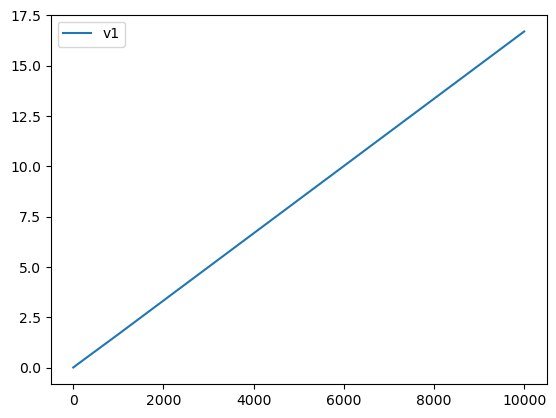

In [136]:
plt.plot(sizes, tims, label = 'v1')

plt.legend()

## V2

In [168]:
def make_blast_df2(data):
    start = time.time()
    original_cols = data.columns

    data.rename(columns = {original_cols[0]: 'query', original_cols[1]: 'subject'}, inplace = True)

    n_unique_1 = np.unique(data['query'])
    n_unique_2 = np.unique(data['subject'])

    qid_dict = dict(zip(n_unique_1, range(len(n_unique_1))))
    sid_dict = dict(zip(n_unique_2, range(len(n_unique_2))))

    data['qid'] = [qid_dict[i] for i in data.iloc[:,0]]
    data['sid'] = [sid_dict[i] for i in data.iloc[:,1]]

    data['pid'] = data.index

    metrics = [
    'local_gap_compressed_percent_id',
    'scaled_local_query_percent_id',
    'scaled_local_symmetric_percent_id',
    'query_align_len',
    'query_align_cov',
    'subject_align_len',
    'subject_align_cov',
    'bit_score'
    ]

    data_dict = data.to_dict('records')
    final = pd.DataFrame(columns = metrics)
    
        
    # Initialize PairWiseAligner with required parameters for model
    aligner = Align.PairwiseAligner()
    aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
    aligner.open_gap_score = -11
    aligner.extend_gap_score = -1
    aligner.mode = 'local'

    alignments = []
    
    final_data = []
    
    for row in data_dict:
        query = row['query']
        subject = row['subject']

        alignment = aligner.align(subject, query)
        best_alignment = max(alignment, key=lambda x: x.score)

        seq1_aligned = best_alignment[0]
        seq2_aligned = best_alignment[1]

        subject_cov = sum(c != '-' for c in seq1_aligned) / len(seq1_aligned)
        query_cov = sum(c != '-' for c in seq2_aligned) / len(seq2_aligned)

        l_subject = len(query)
        l_query = len(subject)

        n_matches, n_gaps, n_columns, n_comp_gaps = get_matches_gaps(seq2_aligned, seq1_aligned)
        gap_comp_pct_id = gap_compressed_percent_id(n_matches, n_gaps, n_columns, n_comp_gaps)

        scaled_local_symmetric_percent_id = 2 * n_matches / (l_subject + l_query)
        scaled_local_query_percent_id = n_matches / l_query

        new_row = [gap_comp_pct_id, scaled_local_query_percent_id, scaled_local_symmetric_percent_id, l_query,
                   query_cov, l_subject, subject_cov, best_alignment.score, row['qid'], row['sid']]

        final_data.append(new_row)

    columns = metrics + ['query_id', 'subject_id']
    final_df = pd.DataFrame(final_data, columns=columns)

    blast_df = data.merge(final_df, left_on=['qid', 'sid'], right_on=['query_id', 'subject_id'])

        
    fin = time.time()
    
    tot = fin - start
    
    return blast_df, tot
 

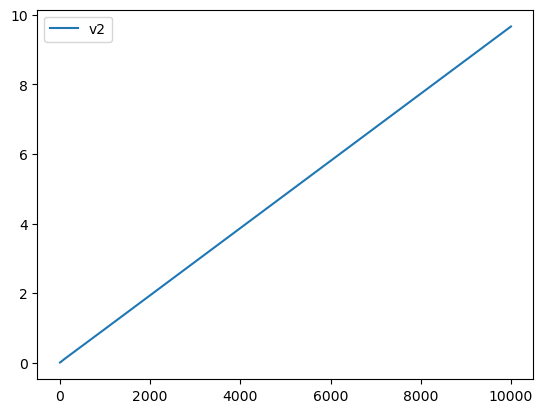

In [188]:
sizes = [1,10,100, 1000, 10000]
tims2 = []
for j in sizes:
    test = con.execute(f"""SELECT * FROM fafsa_final LIMIT {j}""").df()[['m_protein_seq', 't_protein_seq']]
    blast, tot = make_blast_df2(test)
    
    tims2.append(tot)
    
#lt.plot(sizes, tims, label = 'v1')
plt.plot(sizes, tims2, label = 'v2')
plt.legend();

In [189]:
tims2

[0.006041049957275391,
 0.012953519821166992,
 0.10609936714172363,
 0.9721419811248779,
 9.665905237197876]

In [196]:
rates = [j/i for i,j in zip(tims2,sizes)]

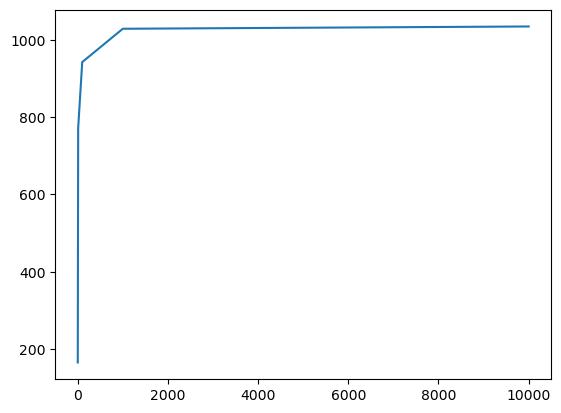

In [197]:
plt.plot(sizes, rates)